In [1]:
import torch
import torch.nn.functional as F
import os
import random
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Reading Names Dataset
print(f"Working dir: {os.getcwd()}")
dataset_path = os.path.join(os.getcwd(), "../makemore/names.txt")
words = open(dataset_path, 'r').read().splitlines()

print(f"\nDataset cherry picking: {words[:8]}")
print(f"Dataset size: {len(words)}")

Working dir: /Users/tomery/Library/CloudStorage/OneDrive-Mobileye/Documents/training_repos/zero_to_hero/exercises

Dataset cherry picking: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Dataset size: 32033


# ------------ Buliding Data Mapping and Dataset ---------------

In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [3]:
# build the datasetc
def build_dataset(dataset = list, block_size = int):
  # block_size: context length, how many characters do we take to predict the next one?
  # returns: X as input features in size of contect length, Y as the labels.
  
  X, Y = [], []
  for w in dataset:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f"Features: {X.shape}, {X.dtype}\nLabels: {Y.shape}, {Y.dtype}")
  return X, Y
  

# Split the dataset to train ; dev/validation ; test
random.seed(42) # Set seed for reproducibility
random.shuffle(words)

block_size = 3 
dev_dataset_index = int(0.8*len(words))
test_dataset_index = int(0.9*len(words))

print("Train:")
Xtr, Ytr = build_dataset(words[:dev_dataset_index], block_size=block_size)
print("Dev:")
Xdev, Ydev = build_dataset(words[dev_dataset_index:test_dataset_index], block_size=block_size)
print("Test:")
Xte, Yte = build_dataset(words[test_dataset_index:], block_size=block_size)

Train:
Features: torch.Size([182625, 3]), torch.int64
Labels: torch.Size([182625]), torch.int64
Dev:
Features: torch.Size([22655, 3]), torch.int64
Labels: torch.Size([22655]), torch.int64
Test:
Features: torch.Size([22866, 3]), torch.int64
Labels: torch.Size([22866]), torch.int64


# ------------ Buliding MLP Architecture ---------------

Text(0.5, 1.0, 'Neural architecture from Bengio et al. 2003 MLP language model paper')

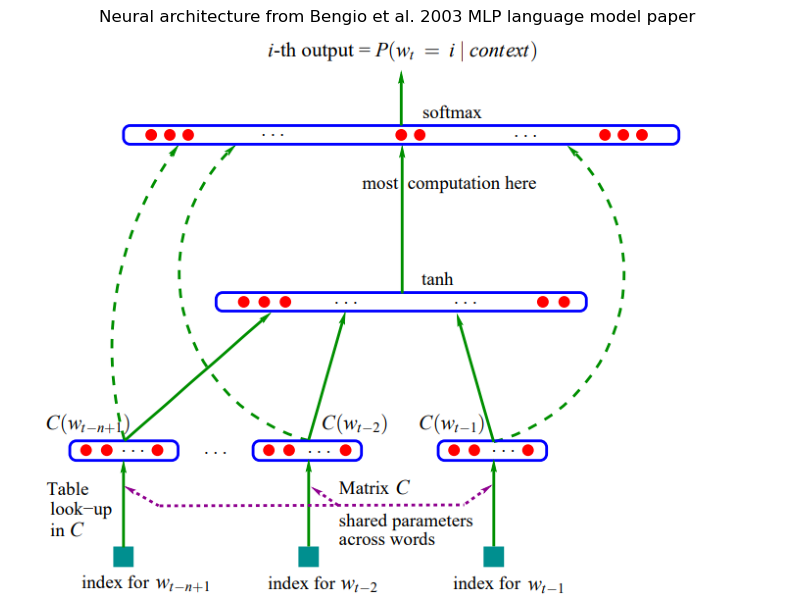

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread("../images/MLP.png"));
plt.axis("off");
plt.title("Neural architecture from Bengio et al. 2003 MLP language model paper")

In [48]:
# Hyperparameters Definition
emb_size = 12
in_size = block_size * emb_size
hidden_size = 256
out_size = len(stoi)

lr = 0.1 # learning rate
lambda_ = 0.01
batch_size = 256
number_of_steps = 200000


g = torch.Generator().manual_seed(2147483647) # for reproducibility

def build_neural_architecture(in_size = int, out_size = int, hidden_size = int, emb_size = int, weights_init = str):
    
    C = torch.randn((out_size, emb_size), generator=g)
    W1 = torch.randn((in_size, hidden_size), generator=g)
    b1 = torch.randn(hidden_size, generator=g)
    W2 = torch.randn((hidden_size, out_size), generator=g)
    b2 = torch.randn(out_size, generator=g)
        
    if weights_init == "uniform":
        torch.nn.init.uniform_(C, a=0, b=1, generator=g)
        torch.nn.init.uniform_(W1, a=0, b=1, generator=g)
        torch.nn.init.uniform_(b1, a=0, b=1, generator=g)
        torch.nn.init.uniform_(W2, a=0, b=1, generator=g)
        torch.nn.init.uniform_(b2, a=0, b=1, generator=g)
        
    if weights_init == "normal":
        torch.nn.init.normal_(C, mean=0.0, std=0.01, generator=g)
        torch.nn.init.normal_(W1, mean=0.0, std=0.01, generator=g)
        torch.nn.init.normal_(b1, mean=0.0, std=0.01, generator=g)
        torch.nn.init.normal_(W2, mean=0.0, std=0.01, generator=g)
        torch.nn.init.normal_(b2, mean=0.0, std=0.01, generator=g)
        
    parameters = [C, W1, b1, W2, b2]
    print(f"Net total number of hyperparameters: {sum(p.nelement() for p in parameters)}") # number of parameters in total
    for p in parameters:
        p.requires_grad = True
        
    return parameters

C, W1, b1, W2, b2 = build_neural_architecture(in_size=in_size,
                                              out_size=out_size,
                                              hidden_size=hidden_size,
                                              emb_size=emb_size)
parameters = [C, W1, b1, W2, b2]


Net total number of hyperparameters: 16735


## ------------- Train the net -------------

In [49]:
# Track loss index: 
loss_index = []
step_index = []

# Train
def training_net(regularization=False):
  
  for i in range(number_of_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, in_size) @ W1  + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    if regularization:
      loss += lambda_ * (W1**2).mean() + lambda_ * (W2**2).mean()
    #print(loss.item())
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # finetune learning rate:
    used_lr = lr
    if i > 20000 and i < 60000:
      used_lr = 0.01
    elif i >= 200000:
      used_lr = 0.001
    elif i >= 260000:
      used_lr = 0.0001
    
    # update by SGD
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    step_index.append(i)
    loss_index.append(loss.log10().item())
    
    if i % 10000 == 0:
          print(f"mini batch {i} | loss {loss.item()} at lr {used_lr}")

training_net(regularization=False)

mini batch 0 | loss 28.911802291870117 at lr 0.1
mini batch 10000 | loss 2.2814035415649414 at lr 0.1
mini batch 20000 | loss 2.309274673461914 at lr 0.1
mini batch 30000 | loss 2.2055647373199463 at lr 0.01
mini batch 40000 | loss 2.2522640228271484 at lr 0.01
mini batch 50000 | loss 1.998245120048523 at lr 0.01
mini batch 60000 | loss 2.1480824947357178 at lr 0.1
mini batch 70000 | loss 2.1226272583007812 at lr 0.1
mini batch 80000 | loss 2.1110434532165527 at lr 0.1
mini batch 90000 | loss 2.05253005027771 at lr 0.1
mini batch 100000 | loss 2.3112096786499023 at lr 0.1
mini batch 110000 | loss 2.2269463539123535 at lr 0.1
mini batch 120000 | loss 2.12321138381958 at lr 0.1
mini batch 130000 | loss 2.2633118629455566 at lr 0.1
mini batch 140000 | loss 2.178358554840088 at lr 0.1
mini batch 150000 | loss 2.0364460945129395 at lr 0.1
mini batch 160000 | loss 2.112117052078247 at lr 0.1
mini batch 170000 | loss 2.2389109134674072 at lr 0.1
mini batch 180000 | loss 2.0618607997894287 at 

2.078932523727417


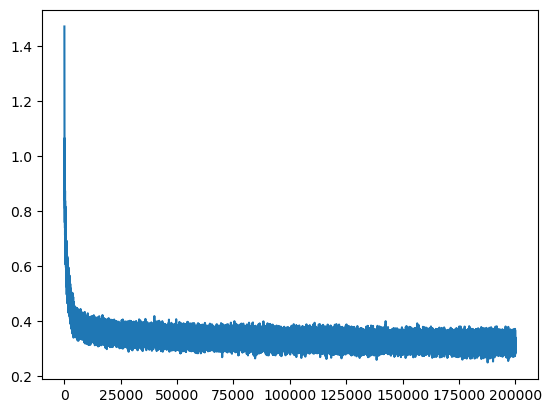

In [7]:
# Plot loss stats:
print(loss.item())
plt.plot(step_index, loss_index)

In [30]:
# Trail to use uniform weights as initiatives: 
C, W1, b1, W2, b2 = build_neural_architecture(in_size=in_size,
                                              out_size=out_size,
                                              hidden_size=hidden_size,
                                              emb_size=emb_size,
                                              weights_init="uniform")
parameters = [C, W1, b1, W2, b2]

Net total number of hyperparameters: 16735


In [32]:
# Trail to use normal weights as initiatives: 
C, W1, b1, W2, b2 = build_neural_architecture(in_size=in_size,
                                              out_size=out_size,
                                              hidden_size=hidden_size,
                                              emb_size=emb_size,
                                              weights_init="normal")
parameters = [C, W1, b1, W2, b2]

Net total number of hyperparameters: 16735


## ------------- Net Evaluation -------------

In [50]:
# training split, dev/validation split, test split

# Train evaluation:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
print(f"Loss evaluation by cross entropy for train dataset: {loss}")

# Train evaluation:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(f"Loss evaluation by cross entropy for dev/validation dataset: {loss}")

# Test evaluation:
emb = C[Xte] 
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yte)
print(f"Loss evaluation by cross entropy for test dataset: {loss}")

Loss evaluation by cross entropy for train dataset: 2.092907667160034
Loss evaluation by cross entropy for dev/validation dataset: 2.1549012660980225
Loss evaluation by cross entropy for test dataset: 2.1554229259490967


### Weights initialization practices:

#### Loss with random weights:
- Loss evaluation by cross entropy for train dataset: 29.80266761779785
- Loss evaluation by cross entropy for dev/validation dataset: 29.68462562561035
- Loss evaluation by cross entropy for test dataset: 29.788822174072266

#### Loss with uniform probabilities weights:
- Loss evaluation by cross entropy for train dataset: 10.25240421295166
- Loss evaluation by cross entropy for dev/validation dataset: 10.253077507019043
- Loss evaluation by cross entropy for test dataset: 10.250718116760254

#### Loss with normal ditribution probabilities weights:
- Loss evaluation by cross entropy for train dataset: 3.296841859817505
- Loss evaluation by cross entropy for dev/validation dataset: 3.2968339920043945
- Loss evaluation by cross entropy for test dataset: 3.2967920303344727

Normal distribution initialization is the best practice for this MLP net.

### Loss calculation with Regularization term:

In [46]:
# Train with regularization to see if it effects the loss:
training_net(regularization=True)

mini batch 0 | loss 3.477339506149292 at lr 0.1
mini batch 10000 | loss 2.303758144378662 at lr 0.1
mini batch 20000 | loss 2.353023052215576 at lr 0.1
mini batch 30000 | loss 2.1910641193389893 at lr 0.01
mini batch 40000 | loss 2.183338165283203 at lr 0.01
mini batch 50000 | loss 2.1013529300689697 at lr 0.01
mini batch 60000 | loss 2.213787794113159 at lr 0.1
mini batch 70000 | loss 2.1518149375915527 at lr 0.1
mini batch 80000 | loss 2.104588508605957 at lr 0.1
mini batch 90000 | loss 2.055626392364502 at lr 0.1
mini batch 100000 | loss 2.0500452518463135 at lr 0.1
mini batch 110000 | loss 1.9856961965560913 at lr 0.1
mini batch 120000 | loss 2.052769660949707 at lr 0.1
mini batch 130000 | loss 2.1200649738311768 at lr 0.1
mini batch 140000 | loss 2.0712411403656006 at lr 0.1
mini batch 150000 | loss 2.137861967086792 at lr 0.1
mini batch 160000 | loss 2.1071505546569824 at lr 0.1
mini batch 170000 | loss 2.088256359100342 at lr 0.1
mini batch 180000 | loss 2.172618865966797 at lr 

#### Loss without regularization:
- Loss evaluation by cross entropy for train dataset: 2.092907667160034
- Loss evaluation by cross entropy for dev/validation dataset: 2.1549012660980225
- Loss evaluation by cross entropy for test dataset: 2.1554229259490967

#### Loss with regularization:
- Loss evaluation by cross entropy for train dataset: 2.0847082138061523
- Loss evaluation by cross entropy for dev/validation dataset: 2.1418871879577637
- Loss evaluation by cross entropy for test dataset: 2.139636993408203

It can be seen that regularization is not effected too much on the current net.

## -------- Inference --------

In [51]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 21)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize word.
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

deksaiba.
tobi.
phi.
abane.
lizikael.
kaitan.
raysleigh.
breylon.
aika.
elin.
raniyannoxlani.
caelynn.
rareyasie.
teo.
greia.
kayson.
preck.
evani.
mavi.
amain.
